https://www.aps.anl.gov/Beamline-Selection/Technical-Information/Storage-Ring-Parameters

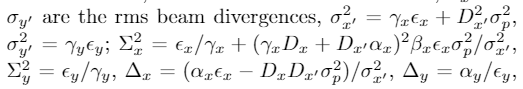

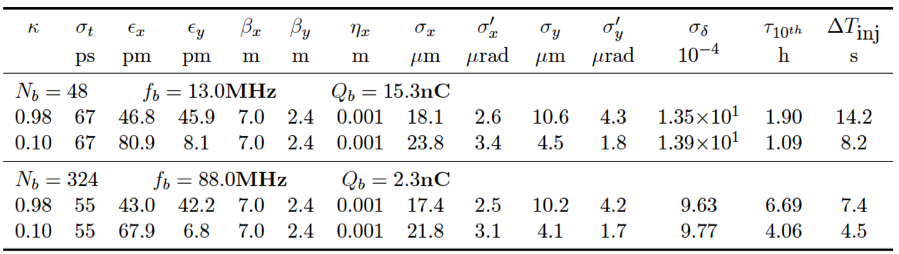

In [1]:
import numpy as np
Ku = 1.65
lamu = 1.8e-2
gamma = 6e9/0.511e6
lam1 = lamu/2/gamma**2*(1+Ku**2/2)
ex = 46.8e-12 # m
kappa = 0.98
ey = 45.9e-12
# betax, betay = 
sx = 18.1e-6
sy = 10.6e-6
bx = sx**2/ex
by = sy**2/ey
sxp = 2.6e-6
syp = 4.3e-6
gx = sxp**2/ex
gy = syp**2/ey
sdp = 13.5*1e-4
Dx = 0.001
lam1

1.541429903125e-10

In [2]:
1240e-9/lam1

8044.478684928198

In [3]:
(gx*Dx)**2*bx*ex*sdp**2/sxp**2/(ex/gx)

0.0056876736111111095

In [4]:
sz = 67e-12*3e8
Nu = 1.8/lamu
skrel = 14.1e-4
sk = skrel*2*np.pi/lam1
sl = skrel*lam1
Ml = 2*sk*sz
Ne = 15.3e-9/1.6e-19
avN = np.pi/2*1/137*Nu*Ne*skrel*np.sqrt(2*np.pi)
usx = 1/gamma*np.sqrt((1+Ku**2/2)/Nu)
usy = usx
k0 = 2*np.pi/lam1
M = np.sqrt(
    (1+4*sk**2*sz**2)
    * (1+4*k0**2*sx**2*(sxp**2+usx**2)+sxp**2/usx**2)
    * (1+4*k0**2*sy**2*(syp**2+usy**2)+syp**2/usy**2)
)
Ne, Ml, avN, usx, M, lam1*1e6, k0*sx*usx, k0*sy*usy, k0*sx*sxp, k0*sy*syp, sxp, usx, 8*sk*sz*k0**2*sxp*syp*usx*usy, lam1

(95625000000.00002,
 2310474.896455102,
 387507225.5463844,
 1.3087016055469295e-05,
 544351586.2729,
 0.0001541429903125,
 9.655511791901608,
 5.654609115699285,
 1.9182623871277853,
 1.8579345432487135,
 2.6e-06,
 1.3087016055469295e-05,
 29403328.53668756,
 1.541429903125e-10)

In [5]:
sl/lam1

0.00141

In [6]:
k0*sx*usx, k0*sy*usy, k0*sx*sxp, k0*sy*syp

(9.655511791901608, 5.654609115699285, 1.9182623871277853, 1.8579345432487135)

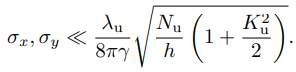

In [7]:
lamu/8/np.pi/gamma*np.sqrt(Nu*(1+Ku**2/2))

9.372884829979215e-07

In [8]:
sxp, usx, syp, usy

(2.6e-06, 1.3087016055469295e-05, 4.3e-06, 1.3087016055469295e-05)

In [9]:
np.sqrt(
    (1+4*sk**2*sz**2)
    * (1+4*k0**2*sx**2*(usx**2))
    * (1+4*k0**2*sy**2*(usy**2)))

507238088.11476636

In [10]:
1240*1e-9/1.54e-10

8051.948051948051

In [11]:
lam1

1.541429903125e-10

In [12]:
lam1/(4*np.pi)/(7*1/206264.8)*1e6

0.36144398005850736

In [13]:
(7.395*1/206264.8)

3.585197280389092e-05

In [14]:
1*1/gamma*np.sqrt((1+Ku**2/2)/Nu)

1.3087016055469295e-05

In [15]:
lam1/(4*np.pi)/(1*1/gamma*np.sqrt((1+Ku**2/2)/Nu))

9.372884829979214e-07

In [16]:
skrel

0.00141

In [17]:
1/(Nu)

0.009999999999999998

In [18]:
import sys

from wigrad import Wiggler, WigglerRadiationSimulator

import scipy.signal
from scipy.optimize import minimize
import pandas as pd
pd.set_option('max_columns', None)
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var
from fur.one_data_set_analyzer import analyze_one_dataset
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data, get_acnet_df_with_bunch_sizes
shift = path_assistant.PathAssistant('shift_03_16_2020',
    ignore_files=['RefCurve_2020-03-16_0_084020_test.Wfm.bin',
                  'RefCurve_2020-03-16_153_155200.Wfm.bin'])
#shift_03_09_2020.show_waveform_file_names()
waveforms_dir = shift.get_waveforms_dir()
results_dir = shift.get_results_dir()
from config import get_from_config, save_to_config
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
import lattice.lattice as lattice
from lattice.summary_in_undulator import CalcTransverseBeamParams
from wiggler_radiation.Wigrad.wigrad_generator import \
    generate_wr_sim_with_wigrad_results_and_spectral_transmission
import coherent_modes_cpp as cm



m0 = 10000
mfold = 11
seed = 1


wiggler = Wiggler(K_peak=Ku, N_periods=Nu, lambda_wiggler_m=lamu)
xmax = 0.5*7.395*1/206264.8 #3*1/gamma*np.sqrt((1+Ku**2/2)/Nu)  # rad
ymax = xmax  # rad
n_x = 400  # after using symmetries the size will be twice that
n_y = 400  # after using symmetries the size will be twice that
n_l = 100
lmin = (lam1-3*sl)*1e6  # um
lmax = (lam1+3*sl)*1e6  # um
x_step = xmax/(n_x-1)
y_step = ymax/(n_y-1)
l_step = (lmax-lmin)/(n_l-1)
# this mesh is only for positive theta_x and theta_y, the results will be extended later using symmetries (two mirror symmetries: along y-axis and along x-axis)
mesh = (np.linspace(x_step/2, xmax, n_x),
        np.linspace(y_step/2, ymax, n_y),
        np.linspace(lmin, lmax, n_l))

spect = np.exp(-1/2/(sl*1e6)**2*(np.linspace(lmin, lmax, n_l)-lam1*1e6)**2)

wr_sim = WigglerRadiationSimulator(
    wiggler,
    mesh,
    gamma=gamma,
    harmonics=[1],  # harmonics to be calculated have to be specified
    aperture=None,  # as of now the only other option is 'ellipse'
    spectral_transmission=None  # you can provide transmission of filters, QE of detector here, 1D array of the same length as the wavelengths array
    )

wr_sim.calc_amplitude_on_meshgrid()

wr_sim.extend_results_using_symmetries()

ampx3d = wr_sim.get_amplittude_3D(polarization='x')

xmin = -xmax
ymin = -ymax

dax = x_step
day = y_step
dl = l_step
elliptic_aperture = \
        (wr_sim.x_3D**2/xmax**2+wr_sim.y_3D**2/ymax**2) < 1
sm =dax*day*dl*np.sum(
    spect[:,None,None]*np.absolute(ampx3d*elliptic_aperture)**2)


# In[13]:


st = sz*1e6
Sx, Sy, dx, dy, sxp, syp = sx*1e6, sy*1e6, 0, 0, sxp, syp
coh_modes_cpp_args =  np.asarray([Sx,Sy,dx,dy,sxp,syp,xmin,xmax,ymin,ymax,lmin,lmax,
                                  st, sm, m0,mfold,seed],
                                dtype=np.float64)
Mi = np.real(
    cm.CalcMFromPrecalculatedFieldAmps(ampx3d,spect,coh_modes_cpp_args)[-1])
print(Mi)

125115906.60523535


In [19]:
print(f"{Mi:.1e}")

1.3e+08


In [20]:
print(f"{sm*Ne:.1e}")

2.9e+08


In [21]:
sm*Ne/Mi

2.3318502821037486

In [22]:
print(f"{Ne:.1e}")

9.6e+10


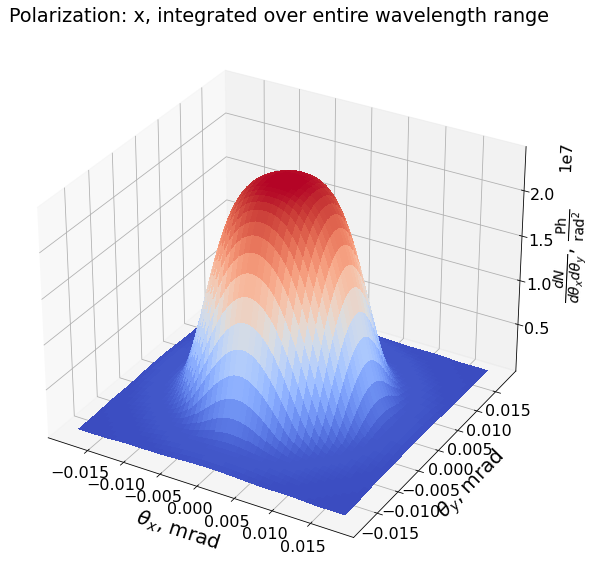

In [23]:
wr_sim.show_angular_distribution(polarization='x')

In [24]:
mesh

(array([2.24636421e-08, 6.73346265e-08, 1.12205611e-07, 1.57076595e-07,
        2.01947580e-07, 2.46818564e-07, 2.91689548e-07, 3.36560533e-07,
        3.81431517e-07, 4.26302501e-07, 4.71173486e-07, 5.16044470e-07,
        5.60915454e-07, 6.05786439e-07, 6.50657423e-07, 6.95528408e-07,
        7.40399392e-07, 7.85270376e-07, 8.30141361e-07, 8.75012345e-07,
        9.19883329e-07, 9.64754314e-07, 1.00962530e-06, 1.05449628e-06,
        1.09936727e-06, 1.14423825e-06, 1.18910924e-06, 1.23398022e-06,
        1.27885120e-06, 1.32372219e-06, 1.36859317e-06, 1.41346416e-06,
        1.45833514e-06, 1.50320613e-06, 1.54807711e-06, 1.59294809e-06,
        1.63781908e-06, 1.68269006e-06, 1.72756105e-06, 1.77243203e-06,
        1.81730302e-06, 1.86217400e-06, 1.90704499e-06, 1.95191597e-06,
        1.99678695e-06, 2.04165794e-06, 2.08652892e-06, 2.13139991e-06,
        2.17627089e-06, 2.22114188e-06, 2.26601286e-06, 2.31088384e-06,
        2.35575483e-06, 2.40062581e-06, 2.44549680e-06, 2.490367